# Measuring Campaign ROI

**Main Question: How can we measure and maximize the return on investment (ROI) for personalized marketing efforts?** \
**Objective:** Develop a model that predicts the ROI of different marketing campaigns, incorporating factors like conversion rate, customer lifetime value
(CLV), and acquisition cost.\
**Expected Outcome:** Provide recommendations on which campaign strategies yield the best ROI.

### Table of Contents
1. Problem Analysis
2. Data Preprocessing
3. Exploratory Data Analysis (EDA)
4. Acquisition Cost Sub-Model
5. Conversion Rate Sub-Model
6. ROI Model

### 1. Problem Analysis

In the highly competitive banking industry, it is important for banks to maintain their competitiveness by focusing their marketing efforts on campaigns that generate the highest return on investment (ROI). However, banks often struggle to quantify the ROI for different marketing efforts, making it difficult to determine which campaigns generate the highest profitability and long-term customer value. Therefore, being able to measure and predict the ROI of marketing campaigns is crucial for efficient allocation of marketing budgets, ensuring that a bank employs the most effective marketing strategy.

To tackle this challenge, we aim to develop a model that can predict the ROI of various bank marketing campaigns based on key influencing factors such as conversion rate and acquisition cost. Conversion rate and acquisition cost will be estimated using 2 individual models, using campaign-specific features such as campaign type (email marketing, telemarketing, etc), campaign duration, target audience, campaign langauge, and campaign timeframe as inputs. Then, the outputs of these 2 sub-models will be used to develop a model to predict ROI.

Through this, not only are we able to predict and quantify the cost-effectiveness of a given marketing campaign, but also generate recommendations on which bank marketing campaigns a bank should focus on.

### 2. Data Preprocessing

In [1109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# load datasets
campaigns_df = pd.read_csv("../../data/processed/campaigns.csv")
customer_df =  pd.read_csv("../../data/processed/customer.csv")
engagement_details_df = pd.read_csv("../../data/processed/engagement_details.csv")
engagement_details_df.head(), customer_df.head(), campaigns_df.head()
campaigns_df

,campaign_id,campaign_type,target_audience,campaign_duration,conversion_rate,acquisition_cost,roi,campaign_language,impressions,clicks
0,71,Display Advertising,35-44,75,0.1177,61.81,1.901301,Spanish,7548,888.0
1,34,Display Advertising,35-44,30,0.0597,15.03,0.949611,Spanish,22603,1349.0
2,63,Affiliate Marketing,25-34,60,0.1664,292.83,2.400897,Mandarin,43584,7252.0
3,21,Search Engine Optimization,45-54,60,0.1189,69.84,1.803662,Spanish,3877,461.0
4,48,Display Advertising,45-54,60,0.0751,47.46,2.208150,German,9915,745.0
...,...,...,...,...,...,...,...,...,...,...
94,33,Display Advertising,25-34,15,0.0520,30.56,1.276915,German,32369,1683.0
95,16,Email Marketing,25-34,30,0.0214,3.61,0.655859,Spanish,49528,1060.0
96,24,Search Engine Optimization,25-34,15,0.1378,51.58,2.695347,Spanish,38137,5255.0
97,30,Search Engine Optimization,25-34,15,0.1603,154.65,2.444640,German,32162,5156.0


In [1110]:
### Obtaining derived variables ###

# Join engagement_details with customer.csv on customer_id, adding CLV column
engagement_details_with_clv = engagement_details_df.merge(
    customer_df[['customer_id', 'customer_lifetime_value']],
    on='customer_id',
    how='left'
)

# Compute the average CLV per campaign
avg_clv_per_campaign = engagement_details_with_clv.groupby('campaign_id', as_index=False)['customer_lifetime_value'].mean()
avg_clv_per_campaign.rename(columns={'customer_lifetime_value': 'avg_clv'}, inplace=True)

# Merge campaigns.csv with avg_clv_per_campaign on campaign_id
merged_campaigns = campaigns_df.merge(avg_clv_per_campaign, on='campaign_id', how='left')

# Select and rearrange the required columns
df = merged_campaigns[['campaign_id', 'campaign_type', 'target_audience', 'campaign_duration',
                       'campaign_language', 'conversion_rate', 'acquisition_cost', 'avg_clv', 'roi']]
df

,campaign_id,campaign_type,target_audience,campaign_duration,campaign_language,conversion_rate,acquisition_cost,avg_clv,roi
0,71,Display Advertising,35-44,75,Spanish,0.1177,61.81,728.518344,1.901301
1,34,Display Advertising,35-44,30,Spanish,0.0597,15.03,752.844152,0.949611
2,63,Affiliate Marketing,25-34,60,Mandarin,0.1664,292.83,719.763148,2.400897
3,21,Search Engine Optimization,45-54,60,Spanish,0.1189,69.84,742.841625,1.803662
4,48,Display Advertising,45-54,60,German,0.0751,47.46,747.176181,2.208150
...,...,...,...,...,...,...,...,...,...
94,33,Display Advertising,25-34,15,German,0.0520,30.56,754.491278,1.276915
95,16,Email Marketing,25-34,30,Spanish,0.0214,3.61,750.862278,0.655859
96,24,Search Engine Optimization,25-34,15,Spanish,0.1378,51.58,742.031446,2.695347
97,30,Search Engine Optimization,25-34,15,German,0.1603,154.65,743.055399,2.444640


### 3. Exploratory Data Analysis (EDA)

##### Summary Statistics

In [1111]:
# Summary statistics and pairplot to explore relationships
summary_stats = df.describe(include='all')
summary_stats

,campaign_id,campaign_type,target_audience,campaign_duration,campaign_language,conversion_rate,acquisition_cost,avg_clv,roi
count,99.000000,99,99,99.000000,99,99.000000,99.000000,99.000000,99.000000
unique,NaN,5,5,NaN,5,NaN,NaN,NaN,NaN
top,NaN,Display Advertising,35-44,NaN,English,NaN,NaN,NaN,NaN
freq,NaN,40,39,NaN,27,NaN,NaN,NaN,NaN
mean,50.000000,NaN,NaN,39.545455,NaN,0.087360,61.123333,734.303477,1.659057
std,28.722813,NaN,NaN,20.825942,NaN,0.045897,55.976070,23.750505,0.832635
min,1.000000,NaN,NaN,15.000000,NaN,0.011700,2.710000,681.818278,0.454882
25%,25.500000,NaN,NaN,15.000000,NaN,0.054900,24.640000,718.105437,1.033611
50%,50.000000,NaN,NaN,30.000000,NaN,0.078200,38.330000,733.044583,1.610570
75%,74.500000,NaN,NaN,60.000000,NaN,0.117900,79.120000,750.753159,2.052826


In [1112]:
# Log-transform the acquisition_cost column due to high variance
df['log_acquisition_cost'] = np.log(df.acquisition_cost)
# Encode an order for target_audience
df['target_audience'] = pd.Categorical(df.target_audience, ordered=True)

C:\Users\ashle\AppData\Local\Temp\ipykernel_9272\1714423417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_acquisition_cost'] = np.log(df.acquisition_cost)
C:\Users\ashle\AppData\Local\Temp\ipykernel_9272\1714423417.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target_audience'] = pd.Categorical(df.target_audience, ordered=True)


##### Campaign-related features vs Acquisition Cost, Conversion Rate, CLV
First, let's explore the relationships between the campaign-related features and CLV, acquisition cost, conversion rate and respectively. These insights may drive our decisions regarding feature and model selection.

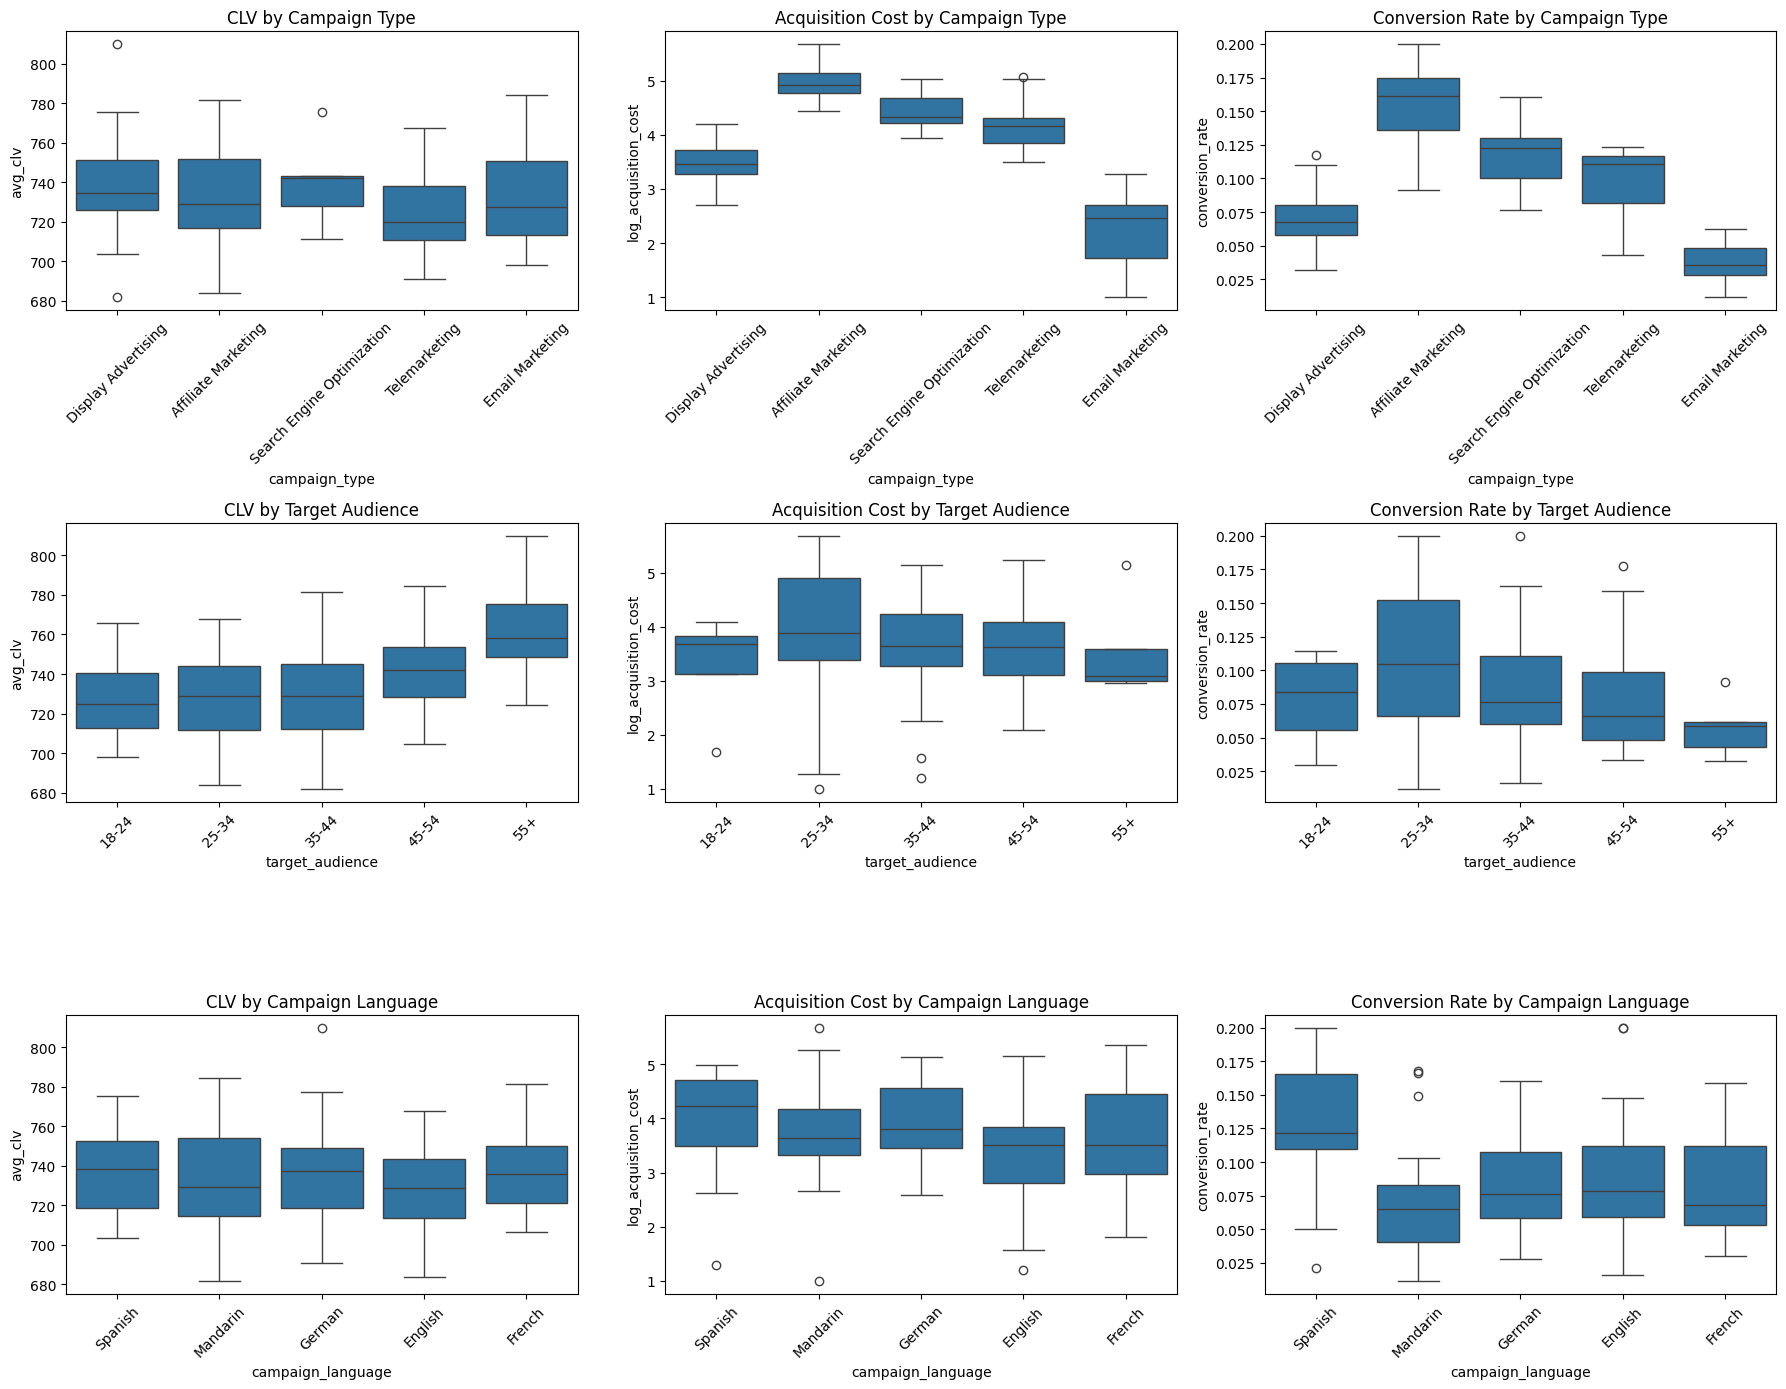

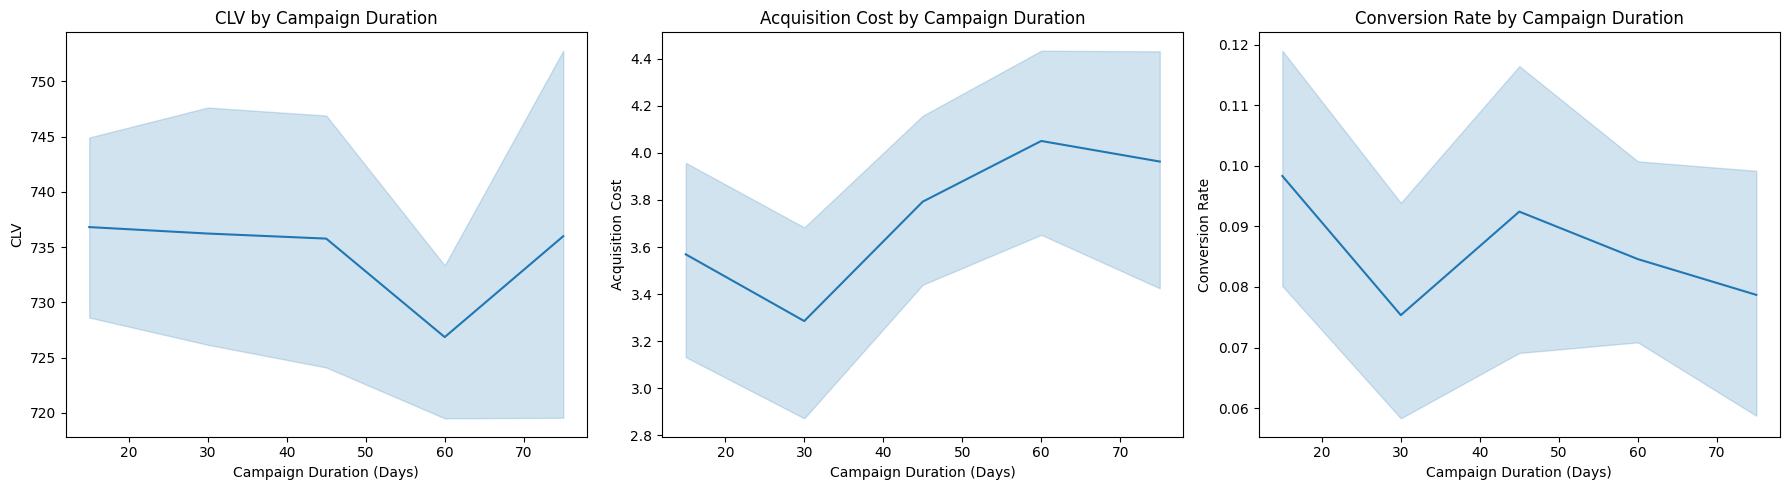

In [1113]:
# Configure grid for categorical feature vs CLV, Cost, Conversion Rate
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
categorical_vars = ['campaign_type', 'target_audience', 'campaign_language']
numerical_targets = ['avg_clv', 'log_acquisition_cost', 'conversion_rate']
titles = ['CLV', 'Acquisition Cost', 'Conversion Rate']

# Plot boxplots for categorical features
for i, cat in enumerate(categorical_vars):
    for j, num in enumerate(numerical_targets):
        sns.boxplot(data=df, x=cat, y=num, ax=axes[i, j])
        axes[i, j].set_title(f'{titles[j]} by {cat.replace("_", " ").title()}')
        axes[i, j].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Plot lineplots for campaign_duration vs each numerical target
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for j, num in enumerate(numerical_targets):
    sns.lineplot(data=df, x="campaign_duration", y=num, ax=axes[j])
    axes[j].set_title(f'{titles[j]} by Campaign Duration')
    axes[j].set_xlabel("Campaign Duration (Days)")
    axes[j].set_ylabel(titles[j])

plt.tight_layout()
plt.show()

**Customer Lifetime Value (CLV):**
- Campaign-related features do not significantly differentiate CLV, indicating it is not campaign-specific
- CLV has a relatively small range (680-810)

Hence, we shall omit CLV from our analysis, as it cannot be differentiated across various camapaigns. If necessary, we may consider using its mean in the computation of ROI.

**Acquisition Cost Sub-Model:** \
*Campaign Type:*
- Highest to lowest cost: Affiliate Marketing > SEO > Telemarketing > Display Advertising > Email Marketing
- Strong differentiating factor

*Target Audience:*
- Median acquisition cost is relatively consistent across target audience groups
- Dropped due to low differentiating power

*Campaign Language:*
- Cost decreases from German → Mandarin → French → Spanish → English
- May consider dropping later

*Campaign Duration*
- Slight positive trend between campaign duration and acquisition cost, which could arise from the need for more resources

For the acquisition cost model, we will implement a Linear Regression model on the features `campaign_type`, `campaign_language` and `campaign_duration`. The Linear Regression model was chosen due to its high interpretability, simplicity, and its optimal performance through trial and error with other models.


**Conversion Rate Sub-Model:** \
*Campaign Type:*
- Highest to lowest conversion: Affiliate Marketing > SEO > Telemarketing > Display Advertising > Email Marketing
- Strong differentiating factor

*Target Audience:*
- Conversion rate generally decreases with increased target audience
- Strong differentiating feature

*Campaign Language:*
- Minimal influence on conversion rate, hence dropped

*Campaign Duration* 
- Minimal influence on conversion rate, hence dropped

For the conversion model, we will implement a Linear Regression model on the features `campaign_type` and `target_audience`. A Linear Regression model was also chosen based on similar reasons as stated above.

### 4. Acquisition Cost Sub-Model

After testing out a few models, a simple Linear Regression model seemed to perform the best. We evaluated the model performance using metrics such as MSE, PMSE, R^2 and adjusted R^2. Then, we extracted the coefficients to analyse the contribution of each variable to the model prediction.

In [1114]:
def cost_model(X, y, categorical_features, numerical_features):
    # Define preprocessor
    preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('num', 'passthrough', numerical_features)
    ])

    # Define pipeline
    linreg_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

    # 5-fold cross-validation due to small dataset size
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Fit model
    linreg_model.fit(X, y)

    # Predict (log scale → original scale)
    log_preds = cross_val_predict(linreg_model, X, y, cv=kf)
    preds = np.expm1(log_preds)
    true_vals = np.expm1(y)

    # Coefficient interpretation
    feature_names = linreg_model.named_steps['preprocessor'].get_feature_names_out()
    log_coefficients = linreg_model.named_steps['regressor'].coef_
    percent_impact = (np.exp(log_coefficients) - 1) * 100

    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Log Coefficient': log_coefficients,
        'Approx % Change in Cost': percent_impact
    }).sort_values(by='Approx % Change in Cost', ascending=False)

    return linreg_model, preds, true_vals, coef_df


In [1115]:
# function to evaluate model performance
def evaluate_model_performance(preds, true_vals, num_features):
    n = len(true_vals)
    mse = mean_squared_error(true_vals, preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_vals, preds)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - num_features - 1)

    print(f"Evaluation Metrics:")
    print(f" - MSE         : {mse:.2f}")
    print(f" - RMSE        : {rmse:.2f}")
    print(f" - R²          : {r2:.3f}")
    print(f" - Adjusted R² : {adj_r2:.3f}")

    return {
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "Adjusted R2": adj_r2
    }

In [1116]:
# run cost model on the selected features
X = df[['campaign_type', 'campaign_duration', 'campaign_language']]
y = df['log_acquisition_cost']
cat_feats = ['campaign_type', 'campaign_language']
num_feats = ['campaign_duration']

model, preds_cost, true_vals, coef_df = cost_model(X, y, cat_feats, num_feats)
coef_df

,Feature,Log Coefficient,Approx % Change in Cost
5,cat__campaign_language_German,0.333317,39.558906
6,cat__campaign_language_Mandarin,0.113517,12.021105
4,cat__campaign_language_French,0.101579,10.691732
8,num__campaign_duration,0.010688,1.074542
7,cat__campaign_language_Spanish,-0.069467,-6.710948
2,cat__campaign_type_Search Engine Optimization,-0.619446,-46.175753
3,cat__campaign_type_Telemarketing,-1.002027,-63.286539
0,cat__campaign_type_Display Advertising,-1.653466,-80.861462
1,cat__campaign_type_Email Marketing,-2.792772,-93.874881


In [1117]:
metrics = evaluate_model_performance(preds_cost, true_vals, num_features=coef_df.shape[0])
metrics

Evaluation Metrics:
 - MSE         : 629.72
 - RMSE        : 25.09
 - R²          : 0.797
 - Adjusted R² : 0.776


{'MSE': 629.7236834950343,
 'RMSE': 25.09429583580767,
 'R2': 0.7969727497357437,
 'Adjusted R2': 0.7764419042034032}

**Model Performance** \
The model has an R^2 value of 0.70, suggesting that the model explains about 70% of the variance in the data. Given that acquisition cost not only lies on price predictions but also the success of the campaign, the model performs decently and is generally reliable.

The model also produces predictions that deviate about $35 (RMSE) away from their actual values. While this may seem unideal, it is still a reasonable margin, given that `acquisition_cost` has high variance (std dev = $65). 

There are some ways to make the model more stable (reduce variance), such as removing outliers, but it often comes at a cost of lower predictive accuracy. Since this model is primarily used to drive business decision-making, we aim for the model to accurately capture relationships between features, even if it is slightly more sensitive to outliers.

**Relationships between Features** \
`campaign_type` and `campaign_language` are key factors that affect the cost of a marketing campaign. Banks who are looking to analyse their marketing expenditure should consider alternative camapign types or languages, while camapign duration should be a secondary consideration.

Campaigns in `German` and `Mandarin` are significantly more expensive, costing almost twice as much as `English` campaigns. This could stem from the need for specialised localization and media targeting in regions where the Portugese bank has limited presence, and limited in-house language resources. In contrast, `Spanish` campaigns are costlier by only 5%. This may be due to a higher volume of English and Spanish speakers in Portugal, as aforementioned. Hence, the Portugese bank should prioritize `English` and `Spanish` campaigns to optimize ROI, and limit high-cost language campaigns like `German` or `Mandarin` unless justified by strong conversion potential.

`Email Marketing` and `Display Advertisting` incurs the lowest cost when compared to `Affiliate Marketing`, reducing cost by 94% and 86% respectively. Hence, for banks that are aiming to cut costs, they could focus more on email marketing campaigns and display advertising, as these channels are easily scalable to a larger audience base without incurring significant additional costs. 

`campaign_duration` only slightly impacts `acquisition_cost`, with longer campaigns associated with an approximate 1% increase. This is likely due to the need for more resources such as manpower, ad space, and continuous tracking of campaign value. However, it is a less significant factor than campaign type, and should not be prioritised as a lever for cost control.

Despite our insights gained on reducing marketing expenditure, we still need to synthesize these insights with the analysis on the value generated from different camapigns to gain a more holistic view of how different campaign types impact ROI.

### 5. Conversion Rate Sub-Model

Similarly, a simple Linear Regression model had the highest performance after experimenting with various models. Dropping the campaign duration feature also seemed to improve the model performance. We perform the same evaluation and analysis as above.

In [1118]:
def conversion_model(X, y, categorical_features):
    # Preprocessor (one-hot encoding for categorical features)
    preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

    # Pipeline with linear regression
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

    # Cross-validation setup
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Fit and predict using cross_val_predict
    model.fit(X, y)
    preds = cross_val_predict(model, X, y, cv=kf)

    # Coefficient extraction
    feature_names = model.named_steps['preprocessor'].get_feature_names_out()
    coefficients = model.named_steps['regressor'].coef_
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    return model, preds, y, coef_df

In [1119]:
X_conv = df[['campaign_type', 'target_audience']]
y_conv = df['conversion_rate']
cat_features_conv = ['campaign_type', 'target_audience']

model_conv, preds_conv, true_conv, coef_df_conv = conversion_model(X_conv, y_conv, cat_features_conv)
coef_df_conv

,Feature,Coefficient
1,cat__campaign_type_Email Marketing,-0.120724
0,cat__campaign_type_Display Advertising,-0.083472
3,cat__campaign_type_Telemarketing,-0.058387
2,cat__campaign_type_Search Engine Optimization,-0.039118
7,cat__target_audience_55+,-0.033955
6,cat__target_audience_45-54,-0.010971
4,cat__target_audience_25-34,0.007888
5,cat__target_audience_35-44,-0.002087


In [1120]:
metrics_conv = evaluate_model_performance(preds_conv, true_conv, num_features=coef_df_conv.shape[0])

Evaluation Metrics:
 - MSE         : 0.00
 - RMSE        : 0.02
 - R²          : 0.757
 - Adjusted R² : 0.735


**Model Performance** \
The model has an R^2 value of 0.73, suggesting that the model explains about 73% of the variance in the data. Given the relatively high R^2 value and low RMSE (2.3%), the model generally has a good predictive ability and is robust against outliers.

**Relationships between Features** \
`Affiliate Marketing` yields the highest conversion rates, followed by `SEO`, `Telemarketing`, `Display Advertising`, and `Email Marketing`. This aligns with model coefficients—for example, `Email Marketing` has a lower `conversion_rate` of ~10.5 percentage points, while `SEO` has a lower `conversion_rate` of ~2.5 points relative to `Affiliate Marketing`. This may be because affiliate campaigns—often driven by influencers—offer a more personalized and relatable experience that builds trust. In contrast, email marketing tends to be less targeting and often gets filtered out by spam detection systems. Banks should consider allocating more resources to Affiliate and SEO campaigns while re-evaluating their email marketing strategy. Recommendations include avoiding spam-triggering keywords and crafting more personalized, targeted email content to improve reach and engagement.

Generally, campaigns targeted at older age groups have lower conversion rates. Compared to potential customers aged `18-24`, targeting the `45–54` and `55+` segments results in lower conversion rates, reduced by ~4.0 and ~3.7 percentage points respectively. This may be due to lower digital engagement or a preference for in-person banking among older customers. Banks should consider prioritizing younger segments for digital campaigns, while exploring alternative channels or messaging strategies to better engage older audiences.

Once again, these insights should be synthesized with those from other models to generate more holistic reccommendations.

# 5. ROI Model

The Acquisition Cost Model and Conversion Rate models both give us some insight into what kinds of campaigns may be a

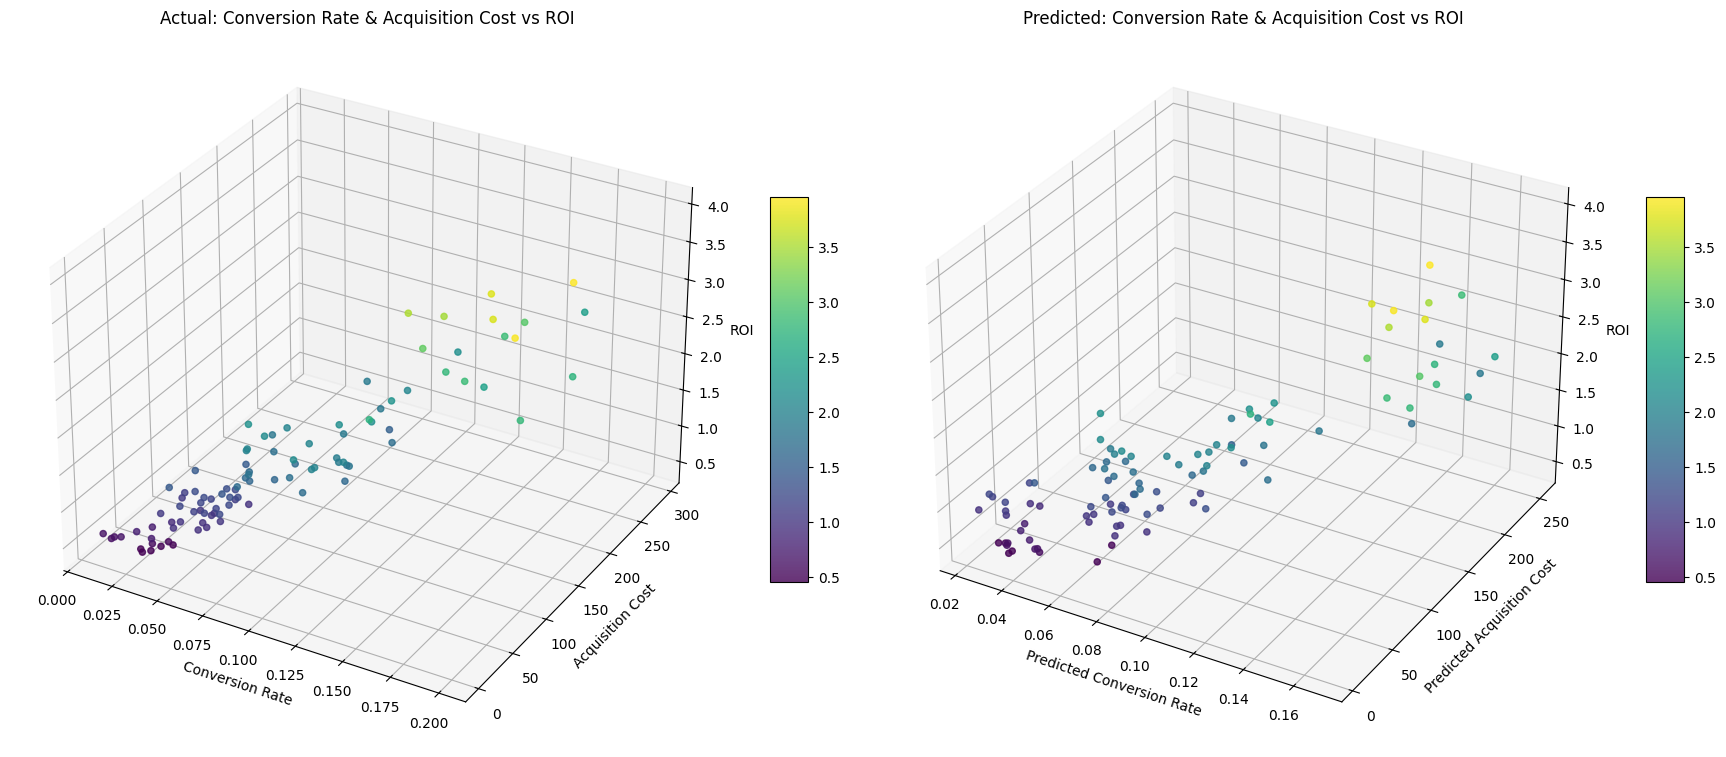

In [1121]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(18, 8))

# Plot 1: Actual conversion rate & acquisition cost vs ROI
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(df['conversion_rate'], df['acquisition_cost'], df['roi'],
                  c=df['roi'], cmap='viridis', alpha=0.8)
ax1.set_xlabel("Conversion Rate")
ax1.set_ylabel("Acquisition Cost")
ax1.set_zlabel("ROI")
ax1.set_title("Actual: Conversion Rate & Acquisition Cost vs ROI")
fig.colorbar(sc1, ax=ax1, shrink=0.5, aspect=10)

# Plot 2: Predicted conversion rate & acquisition cost vs ROI
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(preds_conv, preds_cost, df['roi'],
                  c=df['roi'], cmap='viridis', alpha=0.8)
ax2.set_xlabel("Predicted Conversion Rate")
ax2.set_ylabel("Predicted Acquisition Cost")
ax2.set_zlabel("ROI")
ax2.set_title("Predicted: Conversion Rate & Acquisition Cost vs ROI")
fig.colorbar(sc2, ax=ax2, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()

In [1122]:
# Use collected data on acquisition cost and conversion rate for ROI model
X_roi = df[['acquisition_cost', 'conversion_rate']]
y_roi = df['roi']

# Train ROI model
roi_model = LinearRegression()
cv_scores_roi = cross_val_score(roi_model, X_roi, y_roi, cv=5, scoring='r2')
mean_r2_roi = np.mean(cv_scores_roi)

mean_r2_roi

0.7909872431020373

In [1123]:
# Use only predicted values for final ROI model
X_roi = np.column_stack([preds_conv, preds_cost])
y_roi = df['roi']

# Train ROI model
roi_model = LinearRegression()
cv_scores_roi = cross_val_score(roi_model, X_roi, y_roi, cv=5, scoring='r2')
mean_r2_roi = np.mean(cv_scores_roi)

mean_r2_roi

0.6171912321275641